### HW11_zz1598
## Assignment 1

# Goal: Plot our lovely CUSP building on the Brooklyn Census Block map!

### Data
From http://www1.nyc.gov/ <br/>
zip file that contains the shape file: **nycb2010_16d.zip** <br/>
**[Census Block shape files](http://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nycb2010_16d.zip)**

In [2]:
import numpy as np
import pandas as pd
import seaborn
import os

import geopandas as gpd
import shapely
from shapely.geometry import Point, Polygon
from fiona.crs import from_epsg

import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
if os.getenv ('PUIDATA') is None:
    print ("Must set env variable PUIDATA")  
    os.environ['PUIDATA'] = '/home/cusp/zz1598/PUIdata'
    
print (os.environ['PUIDATA'] ) #print the path of desired directory PUIDATA

/home/cusp/zz1598/PUIdata


## 1. Get and Load Census Block Shape File

In [4]:
def get_CB_data(filename, link):
    '''
    a function to get the census block shape file
    filename: the file to be checked or downloaded in specific place
    link: url for downloading
    '''
    #check if it is in the folder already
    if not os.path.isdir(os.getenv('PUIDATA') + "/" + filename): #dir--extracted file, [filename]
        if not os.path.isfile(os.getenv('PUIDATA') + '/' + filename + '.zip'):   #add .zip
                       
            #if neither extracted file nor zip file exists, then download the zipped shp file from 
            os.system('curl -O ' + link) # download to the current directory)
            print('download successfully, now unzipping...')
        
        # unzip the file, and move from current dir to PUIDATA
        os.system('unzip ' + os.getenv('PUIDATA') + '/' + filename + '.zip -d ' + os.getenv('PUIDATA') + '/' + filename)                
        print ('unzip successfully')
    
    if not os.path.isdir(os.getenv('PUIDATA') + "/" + filename):
        print ('something wrong, folder still does not exist!')
    else:
        print ("file in place, you can continue") 

In [5]:
url = 'http://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nycb2010_16d.zip'
filename = 'nycb2010_16d'

In [6]:
# call the get data function
cb_shape = get_CB_data(filename, url)

file in place, you can continue


In [7]:
# use geopandas to read the shape file
file_path="/nycb2010_16d/nycb2010.shp"
cb_shape = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + file_path)

In [8]:
cb_shape.head(3)

,BCTCB2010,BoroCode,BoroName,CB2010,CT2010,Shape_Area,Shape_Leng,geometry
0,50009001000,5,Staten Island,1000,000900,244589.603884,2508.948115,"POLYGON ((962269.1260375977 173705.5001831055,..."
1,50020011000,5,Staten Island,1000,002001,111006.286826,1345.886422,"POLYGON ((964642.2676391602 161835.2651977539,..."
2,50027001000,5,Staten Island,1000,002700,150406.766022,1703.381172,"POLYGON ((963363.1168212891 167356.3336181641,..."


## 2. Locate Brooklyn shape polygons with coordinates in lat/lon 

In [9]:
# View the names of boroughs
cb_shape.BoroName.unique()

array([u'Staten Island', u'Manhattan', u'Brooklyn', u'Bronx', u'Queens'], dtype=object)

In [10]:
# select only the Brooklyn polygons
cb_bk = cb_shape[cb_shape.BoroName  == 'Brooklyn']
cb_bk = cb_bk.reset_index(drop=True,level=0)  # reset index
cb_bk.head(3)

,BCTCB2010,BoroCode,BoroName,CB2010,CT2010,Shape_Area,Shape_Leng,geometry
0,30002001000,3,Brooklyn,1000,000200,208484.989566,2097.493132,"POLYGON ((982421.0634155273 178133.8510131836,..."
1,30003011000,3,Brooklyn,1000,000301,63365.958361,1006.913933,"POLYGON ((985596.1882324219 193858.6517944336,..."
2,30005011000,3,Brooklyn,1000,000501,116303.194723,1431.900698,"POLYGON ((986271.9053955078 193612.9270019531,..."


### Transform Coordinate System
#### epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet

In [11]:
# Transfrom coordinate system from epsg=2263 to epsg=4326 (lat/lon)
cb_bk.crs = from_epsg(2263) 
cb_bk = cb_bk.to_crs(epsg=4326)

In [12]:
cb_bk.head(3)

,BCTCB2010,BoroCode,BoroName,CB2010,CT2010,Shape_Area,Shape_Leng,geometry
0,30002001000,3,Brooklyn,1000,000200,208484.989566,2097.493132,POLYGON ((-74.00659158337982 40.65561273365177...
1,30003011000,3,Brooklyn,1000,000301,63365.958361,1006.913933,POLYGON ((-73.99514512602698 40.69877384567195...
2,30005011000,3,Brooklyn,1000,000501,116303.194723,1431.900698,POLYGON ((-73.99270830309769 40.69809925981344...


## 3. Locate CUSP : 1 MetroTech Brooklyn. 
### Coordinates: 40.6931° N, 73.9866° W

In [13]:
#Create a Point shapely geometry with the coordinates of CUSP
cusp_geo = Point(-73.9866, 40.6931)

## 4. Find the Census Block that Contains CUSP
Loop over the Brookly polygons and find in which polygon CUSP buiding belongs to

In [14]:
# Loop
cusp_ind = 0
for i, cb  in enumerate(cb_bk.geometry):
    if (cb.contains(cusp_geo) == 1):
        cusp_ind = i
        print('CUSP is contained in', cb.wkt)

('CUSP is contained in', 'POLYGON ((-73.98622595691907 40.69308831340506, -73.98627231669104 40.69219479463375, -73.98729894947923 40.69223407539822, -73.98725396415627 40.6931249027317, -73.98622595691907 40.69308831340506))')


## 5. Plot the CUSP Building within Brooklyn Census Blocks 
1. Plot one every 10 polygons of brooklyn (using the geopandas datafame method plot)
2. overplot the location of CUSP as a point
3. Overplot also the census track that contains cusp in red (using the geopandas datafame method plot)

In [15]:
len(cb_bk)

9682

In [16]:
### Select every 10 polygons from index (Simplified version of Brooklyn)
ind = np.arange(0, len(cb_bk), 10)
cb_bk_simp = cb_bk.ix[ind, :]
cb_bk_simp.head(3)

,BCTCB2010,BoroCode,BoroName,CB2010,CT2010,Shape_Area,Shape_Leng,geometry
0,30002001000,3,Brooklyn,1000,000200,208484.989566,2097.493132,POLYGON ((-74.00659158337982 40.65561273365177...
10,30035001000,3,Brooklyn,1000,003500,10469.636350,507.804498,POLYGON ((-73.97551988364876 40.68675683608991...
20,30054001000,3,Brooklyn,1000,005400,189033.189700,1938.321547,POLYGON ((-74.03649125984288 40.61798915516786...


In [17]:
# Check the number of selected census blocks to be plot on map
print (len(ind))

969


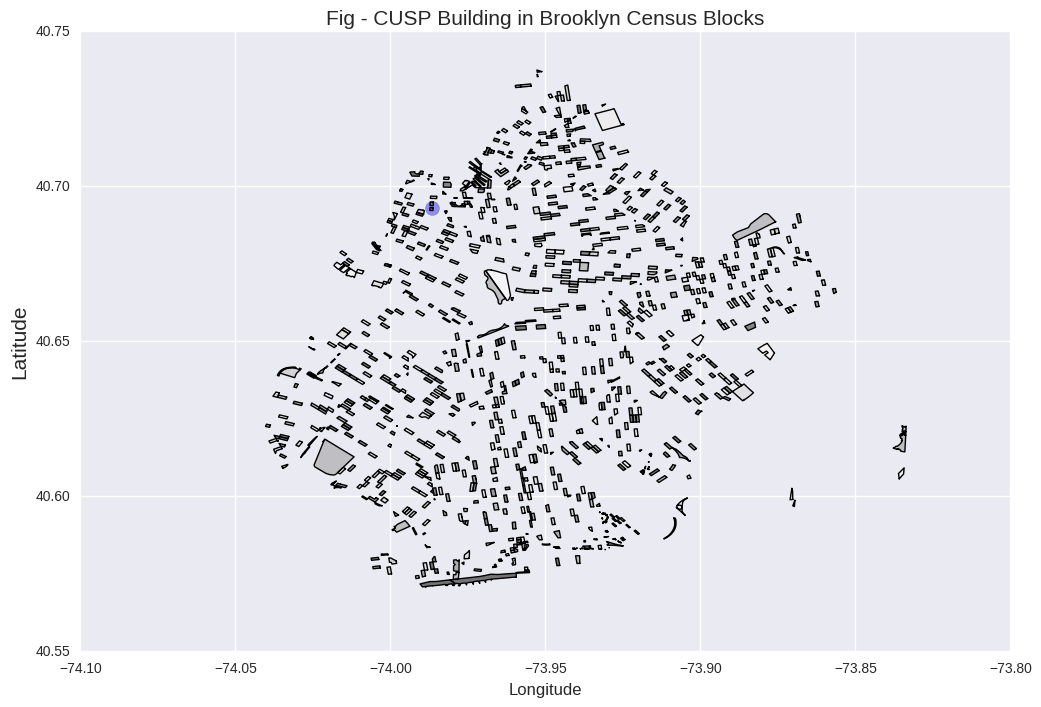

In [18]:
# Plot on map
fig, ax = pl.subplots(1,1, figsize=(12, 8))

cb_bk_simp.plot(ax=ax)
ax.scatter(x=cusp_geo.x, y=cusp_geo.y, c='b', alpha=0.4, s=100)
cb_bk.ix[[cusp_ind]].plot(ax=ax, color='r')

pl.title('Fig - CUSP Building in Brooklyn Census Blocks', fontsize=15)
pl.xlabel('Longitude', fontsize=12)
pl.ylabel('Latitude', fontsize=15)

**Figure**: The map demonstrates the CUSP building(marked as a blue circle) and the census block it is within(marked in red), and the Brooklyn census blocks selected from the census block geodataframe.